In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import sys
import sys
from tqdm.notebook import tqdm
import time
import copy
import argparse
import trimesh
import logging
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

sys.path.insert(0, os.path.abspath('..'))
from incode_experiments import utils, volutils
from incode_experiments import dataio
from modules import INR

#### This notebook is based on the implementation from INCODE: https://github.com/xmindflow/INCODE/

In [44]:
parser = argparse.ArgumentParser(description='LG_SIREN')

# Shared Parameters
parser.add_argument('--input',type=str, default='../data/preprocessed_lucy.npy', help='Input image path')
parser.add_argument('--output',type=str, default='./output/', help='Output path')
parser.add_argument('--inr_model', type=str, default='lg_siren', help='[siren, lg_siren, lc_siren]')
parser.add_argument('--lr',type=float, default=1e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.2, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=1e5, help='Batch size')
parser.add_argument('--niters', type=int, default=20, help='Number if epochs')
parser.add_argument('--steps_til_summary', type=int, default=1, help='Number of steps till summary visualization')
parser.add_argument('--res', type=int, default=512, help='resolution (N^3) of the mesh, same for xyz')
parser.add_argument('--mcubes_thres', type=float, default=0.5, help='Threshold for marching cubes')
parser.add_argument('--downsample', type=int, nargs='+', default=(8, 8, 8), help='Partition factors for Local-Global SIREN')

args = parser.parse_args(args=[])

groups = np.prod(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else 1
args.downsample = tuple(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else (1, 1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [45]:
## Loading .npy file from the pre-processing code
data = np.load(args.input, allow_pickle=True)[()]

### Loading input im with the shape of [res, res, res]
scale = 1.0
im = np.unpackbits(data['im']).reshape(args.res, args.res, args.res)[..., None].astype(np.float32)[...,0]
im = ndimage.zoom(im/im.max(), [scale, scale, scale], order=0)

hidx, widx, tidx = np.where(im > 0.9)
H, W, T = im.shape

### Loading gt_im with the shape of [128, 128, 128] to input into the task-specific model
gt_im = np.unpackbits(data['gt_im']).reshape(128, 128, 128)[..., None].astype(np.float32)[...,0]
gt_im = ndimage.zoom(gt_im/gt_im.max(), [1.0, 1.0, 1.0], order=0)
hidx, widx, tidx = np.where(gt_im > 0.99)
gt_im = gt_im[hidx.min():hidx.max(),
                widx.min():widx.max(),
                tidx.min():tidx.max()]
gt_im = gt_im[None, None, ...]
gt_im = np.repeat(gt_im, 3, axis=1)
gt_im = torch.from_numpy(gt_im).to(device)

### loading the initial pose of mesh 
mesh_whl = data['mesh_whl']

In [46]:
H, W, T

(512, 512, 512)

In [47]:
# Generate coordinate grid
coords, _ = dataio.partition_signal(utils.get_coords(H, W, T, dim=3), (H, W, T), args.downsample)
coords = coords.cuda()

# Convert input image to a tensor and reshape
gt_raw = torch.tensor(im).reshape(H * W * T, 1)[None, ...].to(device)
gt, gt_slices = dataio.partition_signal(torch.tensor(im).reshape(H * W * T, 1), (H, W, T), args.downsample)
gt = gt.cuda()

if 'lg' in args.inr_model or 'lc' in args.inr_model:
    selected_indices = torch.where((gt.squeeze().abs().sum(dim=1) > 0))[0]
    coords_selected = coords[selected_indices]
    gt_selected = gt[selected_indices]
    groups = gt_selected.shape[0]
else:
    selected_indices = torch.where((gt.abs().sum(dim=1) > 0))[0]
    coords_selected = coords
    gt_selected = gt

## Defining Model

### Model Configureations

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [49]:
if args.inr_model == 'lg_siren':
    model = INR(out_features=1, in_features=3, activation_type="sine", mode="lg", num_hidden_layers=3,
                sidelength=512, hidden_features=groups * 17, groups=groups,
                agg_type="concat_and_fc", global_hidden_features=76).cuda()
    print("Total Parameters:", count_parameters(model.net.agg_func) + count_parameters(model.net.global_net) + count_parameters(model.net.net))
    print("Global Parameters:", count_parameters(model.net.agg_func) + count_parameters(model.net.global_net))
    print("Local Parameters:", count_parameters(model.net.net))
elif args.inr_model == 'lc_siren':
    model = INR(out_features=1, in_features=3, activation_type="sine", mode="lc", num_hidden_layers=3,
                sidelength=512, hidden_features=groups * 18,
                groups=groups).cuda()
    count_parameters(model.net.net)
    print("Total Parameters:", count_parameters(model.net.net))
else:
    model = INR(out_features=1, in_features=3, activation_type="sine", mode="mlp", num_hidden_layers=3,
                sidelength=512, hidden_features=256, groups=groups).cuda()
    count_parameters(model.net.net)
    print("Total Parameters:", count_parameters(model.net.net))

Total Parameters: 199174
Global Parameters: 19458
Local Parameters: 179716


## Training Code

In [50]:
# Optimizer setup
optim = torch.optim.Adam(lr=args.lr, params=model.parameters())
scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for IOU and best loss value as positive infinity
iou_values = []
best_iou = torch.tensor(float('inf'))

# Check the args.maxpoints value
args.maxpoints = int(args.maxpoints)

maxpoints = int(math.ceil(min(H*W*T, args.maxpoints) / groups))

### Training Loop

In [51]:
for step in tqdm(range(args.niters)):
    loss_values = []
    for b_idx in tqdm(range(0, H*W*T, args.maxpoints)):
        coord_idx = torch.randint(0, coords_selected.shape[1], (groups, maxpoints)).cuda()
        b_data = torch.gather(gt_selected, dim=1, index=coord_idx.unsqueeze(-1).expand(-1, -1, gt_selected.shape[-1]))
        b_coords = torch.gather(coords_selected, dim=1, index=coord_idx.unsqueeze(-1).expand(-1, -1, coords_selected.shape[-1]))
        
        # Calculate model output
        model_output = model({'coords': b_coords.unsqueeze(0)})['model_out']
        
        # Calculate the output loss
        output_loss = ((model_output - b_data)**2).mean()
        
        loss = output_loss
        loss_values.append(loss.item())

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        if args.inr_model == 'incode' and 30 < step:
            scheduler.step()
        else:
            scheduler.step()
    
    if step >= 1:
        # Evaluation step
        with torch.no_grad():
            rec = torch.zeros_like(gt_selected)
            eval_step_size = 10000
            for i in range(0, coords_selected.shape[1], eval_step_size):
                b_coords = coords_selected[:, i:i+eval_step_size, :]
                model_output = model({'coords': b_coords.unsqueeze(0)})['model_out']
                rec[:, i:i+eval_step_size,:] = model_output
            
            rec_full = torch.zeros_like(gt)
            rec_full[selected_indices] = rec
            rec_full = dataio.lin2vid(rec_full, (H, W, T, 1), gt_slices).reshape(1, H * W * T, 1)

        # Calculate IOU
        with torch.no_grad():
            iou = volutils.get_IoU(rec_full, gt_raw, args.mcubes_thres)
            iou_values.append(iou.item())

        # Prepare reconstructed shape for visualization
        imrec = rec_full[0, ...].reshape(H, W, T).detach().cpu().numpy()

        # Check if the current iteration's loss is the best so far
        if (iou < best_iou) or (step == 0):
            best_iou = iou
            best_img = copy.deepcopy(imrec)

        # Display intermediate results at specified intervals
        if step % args.steps_til_summary == 0:
            print("Epoch: {} | Total Loss: {:.5f} | IoU: {:.4f}".format(step, 
                                                                         np.mean(loss_values),
                                                                         iou.item()))

        
# Print maximum PSNR achieved during training
print('--------------------')
print('Max IoU:', max(iou_values))
print('--------------------')


# Marching and saving volumes
expname = os.path.splitext(os.path.basename(args.input))[0]
os.makedirs(args.output + args.inr_model, exist_ok=True)
savename = f'{args.output}/{args.inr_model}/{expname}.dae'
volutils.march_and_save(best_img, mesh_whl, args.mcubes_thres, savename, True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1343 [00:00<?, ?it/s]

  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 1 | Total Loss: 0.00525 | IoU: 0.9779


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 2 | Total Loss: 0.00434 | IoU: 0.9811


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 3 | Total Loss: 0.00386 | IoU: 0.9823


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 4 | Total Loss: 0.00353 | IoU: 0.9842


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 5 | Total Loss: 0.00326 | IoU: 0.9848


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 6 | Total Loss: 0.00306 | IoU: 0.9855


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 7 | Total Loss: 0.00288 | IoU: 0.9863


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 8 | Total Loss: 0.00272 | IoU: 0.9871


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 9 | Total Loss: 0.00258 | IoU: 0.9880


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 10 | Total Loss: 0.00245 | IoU: 0.9883


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 11 | Total Loss: 0.00233 | IoU: 0.9890


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 12 | Total Loss: 0.00224 | IoU: 0.9894


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 13 | Total Loss: 0.00214 | IoU: 0.9902


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 14 | Total Loss: 0.00205 | IoU: 0.9904


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 15 | Total Loss: 0.00197 | IoU: 0.9908


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 16 | Total Loss: 0.00190 | IoU: 0.9910


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 17 | Total Loss: 0.00183 | IoU: 0.9916


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 18 | Total Loss: 0.00177 | IoU: 0.9920


  0%|          | 0/1343 [00:00<?, ?it/s]

Epoch: 19 | Total Loss: 0.00170 | IoU: 0.9922
--------------------
Max IoU: 0.9921911358833313
--------------------


In [52]:
# Marching and saving volumes
expname = os.path.splitext(os.path.basename(args.input))[0]
os.makedirs(args.output + args.inr_model, exist_ok=True)
savename = f'{args.output}/{args.inr_model}/{expname}_{args.inr_model}_{"_".join([str(d) for d in args.downsample])}_{max(iou_values):.5f}.dae'
volutils.march_and_save(best_img, mesh_whl, args.mcubes_thres, savename, True)

# Convergance Rate

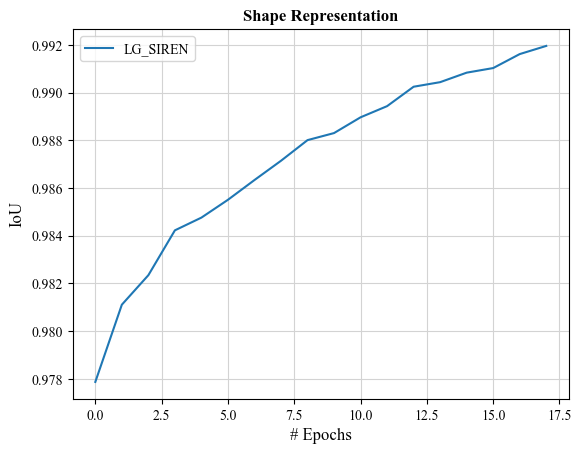

In [53]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(iou_values[:-1])), iou_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('IoU', fontdict=font)
plt.title('Shape Representation', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()